In [9]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from utils.data import load_breast_cancer_kagglehub, standardize_fit_transform
from utils.internal_metrics import (
    silhouette_score,
    davies_bouldin_index,
    calinski_harabasz_index,
    wcss,
)
from utils.external_metrics import (
    adjusted_rand_index,
    normalized_mutual_info,
    purity_score,
)
from GMM import GMM

In [10]:
X, y, feature_names = load_breast_cancer_kagglehub()
scaler = StandardScaler()
Xs = scaler.fit_transform(X) 
print("Data shape:", Xs.shape)

Loaded CSV: /home/amr/.cache/kagglehub/datasets/uciml/breast-cancer-wisconsin-data/versions/2/data.csv
Initial shape: (569, 33)
Dropping 1 columns with all NaN values: ['Unnamed: 32']
Found diagnosis column with values: ['M' 'B']
Dropping non-informative columns: ['id']

Final dataset shape: (569, 30)
Features: 30
Target distribution: Malignant=212, Benign=357
Data shape: (569, 30)


In [11]:
cov_types = ['full', 'tied', 'diag', 'spherical']
components_range = range(1,8)  # try 1 to 7 components

# Dictionary to store results
results = {}

In [12]:
for cov in cov_types:
    bic_list = []
    aic_list = []
    loglik_list = []
    gmm_models = []
    
    for k in components_range:
        gmm = GMM(n_components=k, covariance_type=cov, max_iter=200, random_state=42)
        gmm.fit(Xs)
        
        bic_list.append(gmm.bic(Xs))
        aic_list.append(gmm.aic(Xs))
        loglik_list.append(gmm.log_likelihoods_)
        gmm_models.append(gmm)
    
    results[cov] = {
        'BIC': bic_list,
        'AIC': aic_list,
        'loglik': loglik_list,
        'models': gmm_models
    }

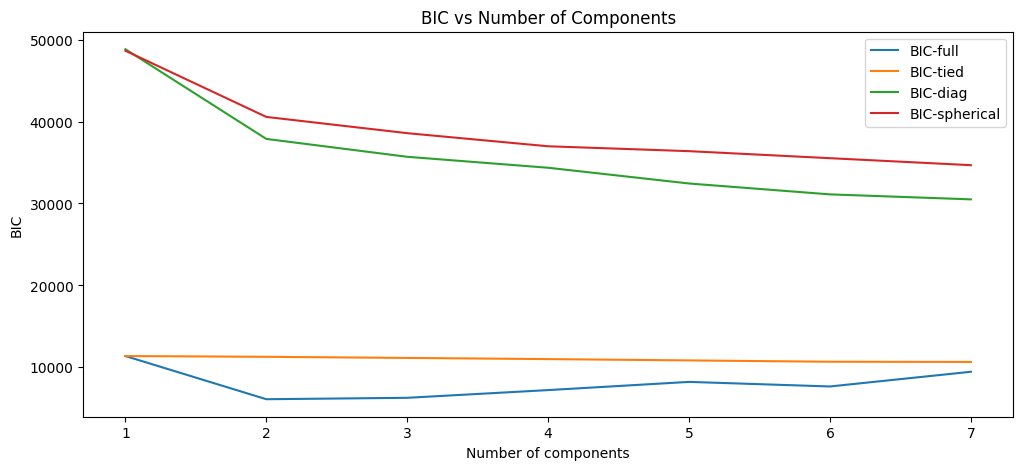

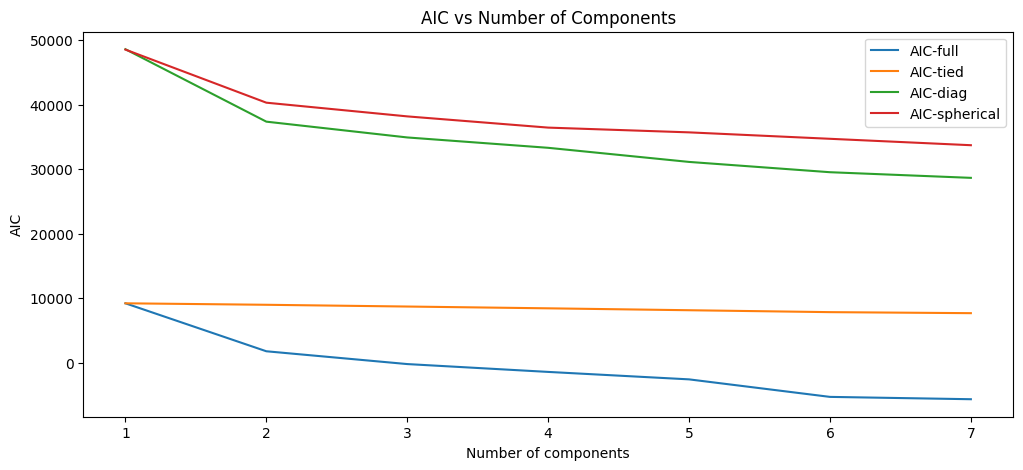

In [13]:
plt.figure(figsize=(12,5))
for cov in cov_types:
    plt.plot(components_range, results[cov]['BIC'], label=f'BIC-{cov}')
plt.xlabel('Number of components')
plt.ylabel('BIC')
plt.title('BIC vs Number of Components')
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
for cov in cov_types:
    plt.plot(components_range, results[cov]['AIC'], label=f'AIC-{cov}')
plt.xlabel('Number of components')
plt.ylabel('AIC')
plt.title('AIC vs Number of Components')
plt.legend()
plt.show()


In [14]:
optimal_components_bic = {}
optimal_components_aic = {}

for cov in cov_types:
    bic_list = results[cov]['BIC']
    aic_list = results[cov]['AIC']
    optimal_components_bic[cov] = components_range[np.argmin(bic_list)]
    optimal_components_aic[cov] = components_range[np.argmin(aic_list)]
print("Optimal number of components based on BIC:", optimal_components_bic)
print("Optimal number of components based on AIC:", optimal_components_aic)


Optimal number of components based on BIC: {'full': 2, 'tied': 7, 'diag': 7, 'spherical': 7}
Optimal number of components based on AIC: {'full': 7, 'tied': 7, 'diag': 7, 'spherical': 7}


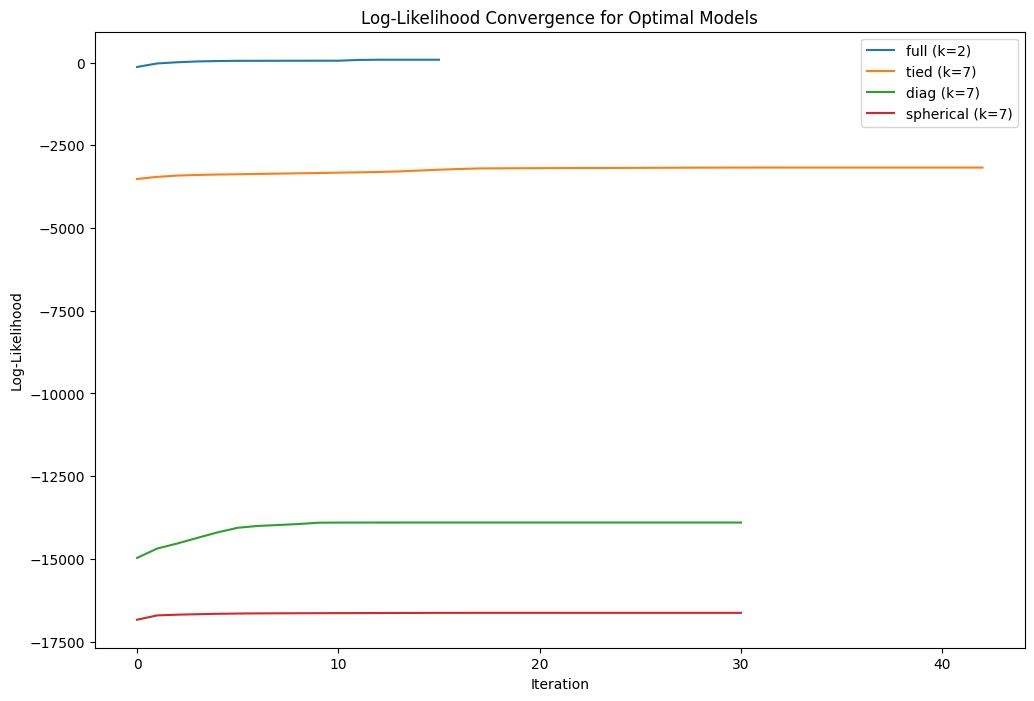

In [15]:
plt.figure(figsize=(12,8))
for cov in cov_types:
    best_k = optimal_components_bic[cov]
    best_gmm = results[cov]['models'][best_k-1]
    plt.plot(best_gmm.log_likelihoods_, label=f'{cov} (k={best_k})')

plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood Convergence for Optimal Models')
plt.legend()
plt.show()



=== Covariance: full | Best k: 2 ===
External Validation Metrics:
ARI: 0.7678, NMI: 0.6542, Purity: 0.9385
Internal Metrics:
Silhouette Score: 0.3146
Davies-Bouldin Index: 1.3794
Calinski-Harabasz Index: 247.0920
WCSS: 11888.9410
BIC: 6115.4584, AIC: 1810.6729, Log-Likelihood: 85.6635


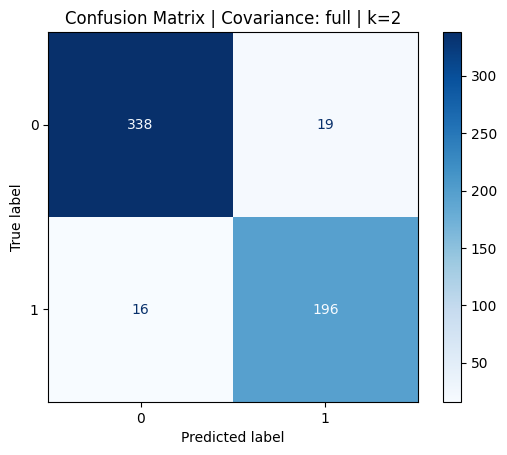


=== Covariance: tied | Best k: 7 ===
External Validation Metrics:
ARI: 0.4215, NMI: 0.4101, Purity: 0.9156
Internal Metrics:
Silhouette Score: 0.1655
Davies-Bouldin Index: 1.7694
Calinski-Harabasz Index: 83.3498
WCSS: 9034.1388
BIC: 10666.1375, AIC: 7707.9550, Log-Likelihood: -3172.9775


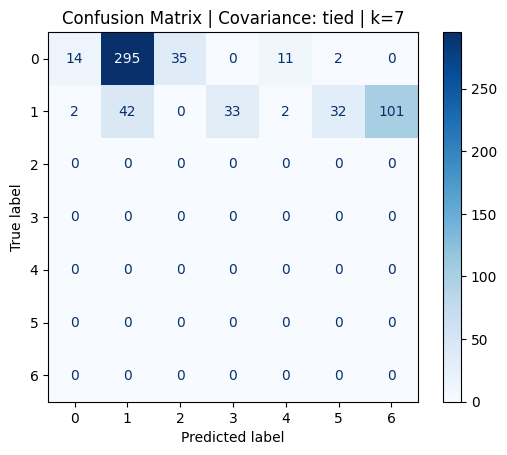


=== Covariance: diag | Best k: 7 ===
External Validation Metrics:
ARI: 0.2412, NMI: 0.3754, Purity: 0.9315
Internal Metrics:
Silhouette Score: 0.0893
Davies-Bouldin Index: 1.9785
Calinski-Harabasz Index: 104.3934
WCSS: 8073.0792
BIC: 30503.4722, AIC: 28652.9792, Log-Likelihood: -13900.4896


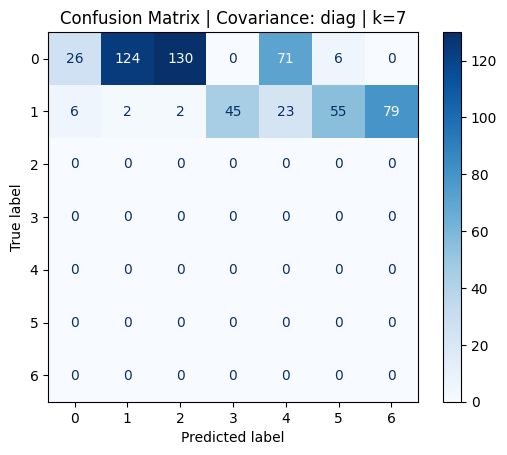


=== Covariance: spherical | Best k: 7 ===
External Validation Metrics:
ARI: 0.2342, NMI: 0.3733, Purity: 0.9174
Internal Metrics:
Silhouette Score: 0.1199
Davies-Bouldin Index: 1.8944
Calinski-Harabasz Index: 106.5015
WCSS: 7989.0201
BIC: 34673.7984, AIC: 33705.1131, Log-Likelihood: -16629.5566


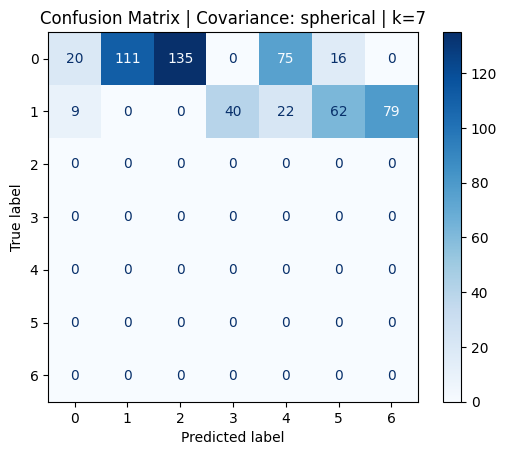

In [16]:
for cov in cov_types:
    best_k = optimal_components_bic[cov]
    best_gmm = results[cov]['models'][best_k-1]
    y_pred = best_gmm.predict(Xs)

    # ------------------- External metrics -------------------
    ari = adjusted_rand_index(y, y_pred)
    nmi = normalized_mutual_info(y, y_pred)
    pur = purity_score(y, y_pred)

    # ------------------- Internal metrics -------------------
    sil = silhouette_score(Xs, y_pred)
    dbi = davies_bouldin_index(Xs, y_pred)
    ch = calinski_harabasz_index(Xs, y_pred)
    wcss_val = wcss(Xs, y_pred, best_gmm.means_)
    bic = best_gmm.bic(Xs)
    aic = best_gmm.aic(Xs)
    log_likelihood = best_gmm.score(Xs)

    # ------------------- Display -------------------
    print(f"\n=== Covariance: {cov} | Best k: {best_k} ===")
    print(f"External Validation Metrics:")
    print(f"ARI: {ari:.4f}, NMI: {nmi:.4f}, Purity: {pur:.4f}")
    print(f"Internal Metrics:")
    print(f"Silhouette Score: {sil:.4f}")
    print(f"Davies-Bouldin Index: {dbi:.4f}")
    print(f"Calinski-Harabasz Index: {ch:.4f}")
    print(f"WCSS: {wcss_val:.4f}")
    print(f"BIC: {bic:.4f}, AIC: {aic:.4f}, Log-Likelihood: {log_likelihood:.4f}")

    # ------------------- Confusion matrix -------------------
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix | Covariance: {cov} | k={best_k}')
    plt.show()
